The evaluation of scanner 2 and scanner 3

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import display
import cv2

def load_and_strip(intensity_file_path):
    intensity_image = nib.load(intensity_file_path)
    affined = intensity_image.affine
    headered = intensity_image.header
    intensity_image = intensity_image.get_fdata()

    # Remove singleton dimensions
    intensity_image = np.squeeze(intensity_image)

    return intensity_image, affined, headered
def extract_numeric_part(filename):
    # Remove file extension
    base_filename, _ = os.path.splitext(filename)
    
    # Extract digits from the modified filename
    digits_only = ''.join(filter(str.isdigit, base_filename))
    
    # Return 0 if no digits are found, otherwise return the integer value
    return int(digits_only) if digits_only else 0

def calling_folders(label_propagation_path):
    label_propagation_files = {}
    patients = [d for d in os.listdir(label_propagation_path) if os.path.isdir(os.path.join(label_propagation_path, d))]

    for patient in patients:
        patient_path = os.path.join(label_propagation_path, patient)
        label_propagation_files[patient] = {}

        for tissue in ['csf', 'gm', 'wm']:
            tissue_path = os.path.join(patient_path, tissue)
            if os.path.isdir(tissue_path):
                result_path = os.path.join(tissue_path, 'result.nii.gz')
                if os.path.exists(result_path):
                    label_propagation_files[patient][tissue] = result_path

    return label_propagation_files

def normalize(img):
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX) # scale the intensities between 0, 255
    img = img.astype(int)
    norm_skull_stripped = img.astype(np.float64)
    return norm_skull_stripped

def label_prop(img, csfs, gms, wms):

    image_bg = np.zeros(img.shape[0])
    stacked_ = np.stack((image_bg, csfs, gms, wms), axis=0)
    labels = np.argmax(stacked_, axis=0)
    return stacked_, labels


def plott(seg, gt):
    slice_index = 145
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(seg[:, :, slice_index], cmap='gray')
    axs[0].axis('off')
    axs[0].set_title(f"Segmentation: Slice {slice_index}")
    # Plot the second image in the second subplot
    axs[1].imshow(gt[:, :, slice_index], cmap='gray')
    axs[1].axis('off')
    axs[1].set_title(f"Ground truth: Slice {slice_index}")
    # Show the plot
    plt.show()

def dice_coefficient(im1, im2):
    intersection = np.sum(im1 * im2)
    dice = 2 * intersection / (np.sum(im1) + np.sum(im2))
    return dice

def compute_dice_for_tissues(im1, im2, label):
    seg = (im1 == label)
    gt = (im2 == label)
    return dice_coefficient(seg, gt)

def dice_coefficient_for_all_tissues(im1, im2):
    # Computing the dice coefficient for each tissue:
    dice_csf = compute_dice_for_tissues(im2, im1, 1)  # CSF
    dice_gm = compute_dice_for_tissues(im2, im1, 2)  # GM
    dice_wm = compute_dice_for_tissues(im2, im1, 3)  # WM

    return dice_csf, dice_gm, dice_wm

Dice coefficient for CSF: 0.7538792716835591
Dice coefficient for GM: 0.86180084534591
Dice coefficient for WM: 0.8170158187259513


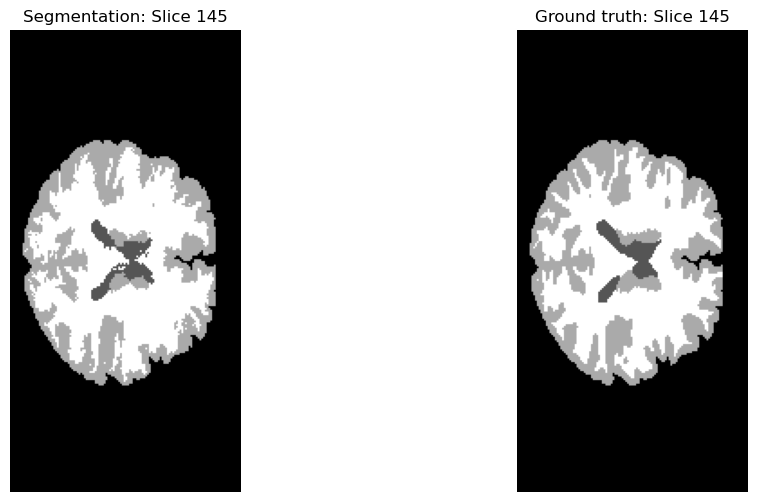

Dice coefficient for CSF: 0.7952442025720129
Dice coefficient for GM: 0.8777266752429239
Dice coefficient for WM: 0.8003482109442375


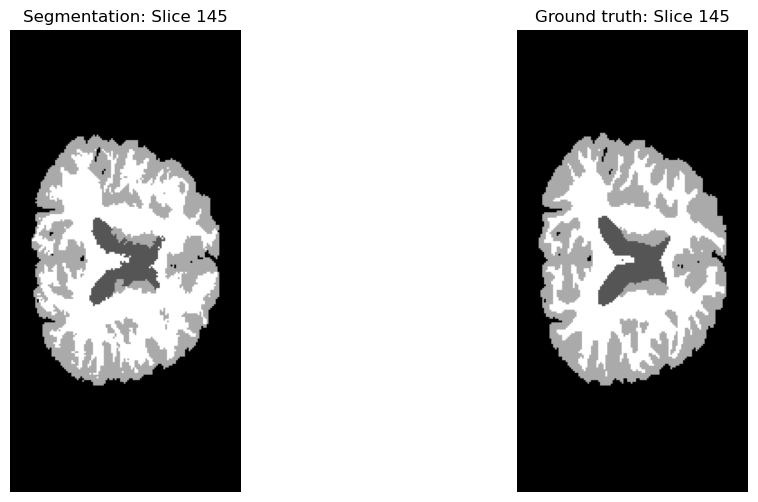

In [4]:
folders = ['11', '12']
base_path = 'C:/Users/hadil/OneDrive/Desktop/Documents/Lectures/MISA/final_project/Validation_Set'
label_propagation_path = 'C:/Users/hadil/OneDrive/Desktop/Documents/Lectures/MISA/final_project/final_project/atlas_2/'

label_propagation_files = calling_folders(label_propagation_path)


for folder, (patient, tissues) in zip(folders, label_propagation_files.items()):
    # Constructing file paths
    intens_path = os.path.join(base_path, f'IBSR_{folder}', f'IBSR_{folder}.nii.gz')
    gt_path = os.path.join(base_path, f'IBSR_{folder}', f'IBSR_{folder}_seg.nii.gz')

    # Load images
    intens_img, affined, headered = load_and_strip(intens_path)
    gt_labels = nib.load(gt_path).get_fdata()

    # Rest of your processing...

    images_intensities = []
    brain_mask = (gt_labels != 0)
    brain_mask = np.squeeze(brain_mask)

    intens_img_1d = intens_img[brain_mask] 
    images_intensities.append(intens_img_1d)
    images_intensities_t = np.asarray(images_intensities).transpose(1, 0)

    csfs = gms = wms = None

    if 'csf' in tissues:
        csfs = nib.load(tissues['csf']).get_fdata()[brain_mask]
    if 'gm' in tissues:
        gms = nib.load(tissues['gm']).get_fdata()[brain_mask]
    if 'wm' in tissues:
        wms = nib.load(tissues['wm']).get_fdata()[brain_mask]

        # print(csfs.shape)
        # print(gms.shape)
        # print(wms.shape)
        # print(images_intensities_t.shape)


        _, labels = label_prop(images_intensities_t, csfs, gms, wms)

        # Reshape labels to match the shape of the indexing result
        labels_reshaped = labels[:, np.newaxis]

        image_shape = gt_labels.shape
        final_cluster_assignments = np.zeros(image_shape, dtype=int)

        final_cluster_assignments[brain_mask] = labels_reshaped

        segmentation_map = final_cluster_assignments.reshape(image_shape)
        
        # evaluate with Dice:
        dice1, dice2, dice3 = dice_coefficient_for_all_tissues(segmentation_map, gt_labels)
        # print(os.path.basename(intensities_path))

        # Print the results:
        print("Dice coefficient for CSF:", dice1)
        print("Dice coefficient for GM:", dice2)
        print("Dice coefficient for WM:", dice3)

        plott(segmentation_map, gt_labels)

Dice coefficient for CSF: 0.797482635828368
Dice coefficient for GM: 0.8829621642815134
Dice coefficient for WM: 0.7538433382137628


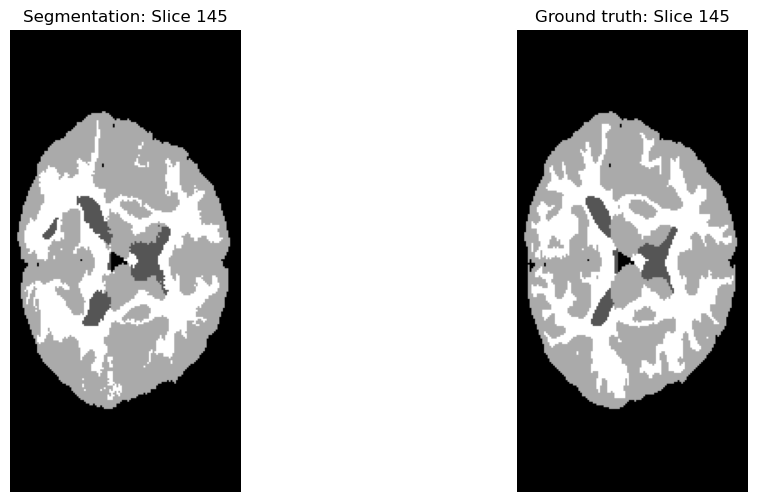

In [5]:
folders = ['17']
base_path = 'C:/Users/hadil/OneDrive/Desktop/Documents/Lectures/MISA/final_project/Validation_Set'
label_propagation_path = 'C:/Users/hadil/OneDrive/Desktop/Documents/Lectures/MISA/final_project/final_project/atlas_3/'

label_propagation_files = calling_folders(label_propagation_path)


for folder, (patient, tissues) in zip(folders, label_propagation_files.items()):
    # Constructing file paths
    intens_path = os.path.join(base_path, f'IBSR_{folder}', f'IBSR_{folder}.nii.gz')
    gt_path = os.path.join(base_path, f'IBSR_{folder}', f'IBSR_{folder}_seg.nii.gz')

    # Load images
    intens_img, affined, headered = load_and_strip(intens_path)
    gt_labels = nib.load(gt_path).get_fdata()

    # Rest of your processing...

    images_intensities = []
    brain_mask = (gt_labels != 0)
    brain_mask = np.squeeze(brain_mask)

    intens_img_1d = intens_img[brain_mask] 
    images_intensities.append(intens_img_1d)
    images_intensities_t = np.asarray(images_intensities).transpose(1, 0)

    csfs = gms = wms = None

    if 'csf' in tissues:
        csfs = nib.load(tissues['csf']).get_fdata()[brain_mask]
    if 'gm' in tissues:
        gms = nib.load(tissues['gm']).get_fdata()[brain_mask]
    if 'wm' in tissues:
        wms = nib.load(tissues['wm']).get_fdata()[brain_mask]

        # print(csfs.shape)
        # print(gms.shape)
        # print(wms.shape)
        # print(images_intensities_t.shape)


        _, labels = label_prop(images_intensities_t, csfs, gms, wms)

        # Reshape labels to match the shape of the indexing result
        labels_reshaped = labels[:, np.newaxis]

        image_shape = gt_labels.shape
        final_cluster_assignments = np.zeros(image_shape, dtype=int)

        final_cluster_assignments[brain_mask] = labels_reshaped

        segmentation_map = final_cluster_assignments.reshape(image_shape)
        
        # evaluate with Dice:
        dice1, dice2, dice3 = dice_coefficient_for_all_tissues(segmentation_map, gt_labels)
        # print(os.path.basename(intensities_path))

        # Print the results:
        print("Dice coefficient for CSF:", dice1)
        print("Dice coefficient for GM:", dice2)
        print("Dice coefficient for WM:", dice3)

        plott(segmentation_map, gt_labels)